In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

Extent       Date
0    917992.880 1979-01-01
1    917992.880 1979-02-01
2    917992.880 1979-03-01
3    917992.880 1979-04-01
4    917992.880 1979-05-01
..          ...        ...
533  728642.743 2023-06-01
534  437024.646 2023-07-01
535  202260.789 2023-08-01
536   98103.856 2023-09-01
537  260413.272 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 16s 192ms/step - loss: 0.6136 - root_mean_squared_error: 0.7833 - val_loss: 0.3894 - val_root_mean_squared_error: 0.6241
Epoch 2/50
53/53 [==============================] - 10s 185ms/step - loss: 0.2825 - root_mean_squared_error: 0.5316 - val_loss: 0.2057 - val_root_mean_squared_error: 0.4535
Epoch 3/50
53/53 [==============================] - 9s 179ms/step - loss: 0.1229 - root_mean_squared_error: 0.3506 - val_loss: 0.1880 - val_root_mean_squared_error: 0.4336
Epoch 4/50
53/53 [==============================] - 10s 185ms/step - loss: 0.1157 - root_mean_squared_error: 0.3402 - val_loss: 0.1794 - val_root_mean_squared_error: 0.4235
Epoch 5/50
53/53 [==============================] - 10s 186ms/step - loss: 0.1075 - root_mean_squared_error: 0.3278 - val_loss: 0.1712 - val_root_mean_squared_error: 0.4138
Epoch 6/50
53/53 [==============================] - 1s 22ms/step - loss: 0.1045 - root_mean_squared_error: 0.3233 - val_loss: 0.1720 - v

Epoch 27/50
53/53 [==============================] - 1s 26ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 28/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0340 - root_mean_squared_error: 0.1843 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2109
Epoch 29/50
53/53 [==============================] - 10s 189ms/step - loss: 0.0331 - root_mean_squared_error: 0.1818 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1983
Epoch 30/50
53/53 [==============================] - 1s 26ms/step - loss: 0.0342 - root_mean_squared_error: 0.1849 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2001
Epoch 31/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0313 - root_mean_squared_error: 0.1768 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2053
Epoch 32/50
53/53 [==============================] - 10s 197ms/step - loss: 0.0320 - root_mean_squared_error: 0.1790 - val_loss: 0.0391 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.368994573752086 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

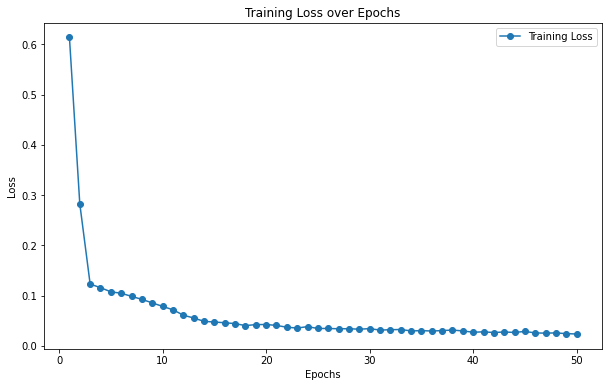

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

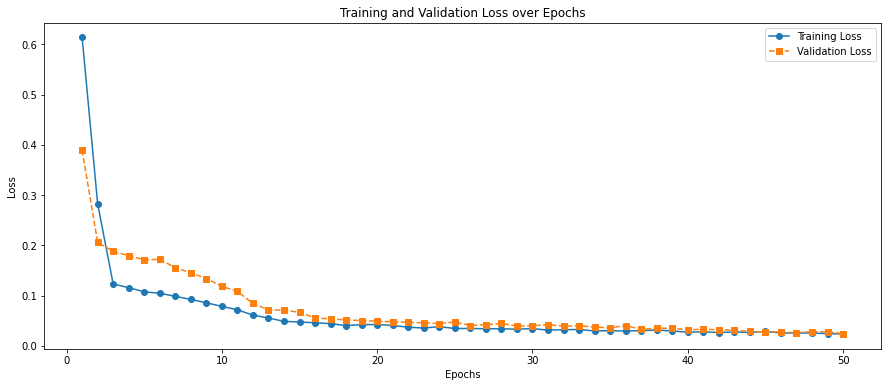

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 15ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.13963919473820796
MAE : 0.11195865549404992


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0       748102.937500     909176.475
1       837823.687500     917006.278
2       868767.375000     906368.363
3       879019.125000     917403.622
4       836133.000000     910653.838
5       719756.437500     822319.125
6       531032.312500     557314.102
7       340243.875000     197129.525
8       181639.218750      75730.217
9       137779.656250      59608.479
10      261941.453125      88785.283
11      629161.750000     396883.400
12      791306.937500     662542.207
13      854739.000000     871431.414
14      872869.187500     917876.960
15      863489.812500     917992.880
16      789275.500000     912733.060
17      643715.687500     910536.463
18      425358.343750     760170.733
19      255168.875000     383812.645
20      161431.421875     201024.515
21      154321.718750     121904.059
22      284798.843750     283554.493
23      623245.375000     702176.823
24      761210.062500     893690.080
25      808919.500000     910117.941
26      841444.312500     889204.715
27      864025.062500     905311.611
28      840630.062500     917930.089
29      748478.687500     912089.899
30      589532.750000     743951.228
31      391650.687500     307180.895
32      232173.453125     104402.284
33      194896.640625      73177.670
34      332609.031250     127085.610
35      700315.562500     650570.950
36      823903.187500     789062.385
37      866397.625000     897053.619
38      888857.187500     904024.315
39      890077.062500     911832.551
40      835485.875000     917992.880
41      708978.312500     894286.938
42      517274.093750     728642.743
43      334486.875000     437024.646
44      190543.781250     202260.789
45      153136.906250      98103.856
46      244725.718750     260413.272

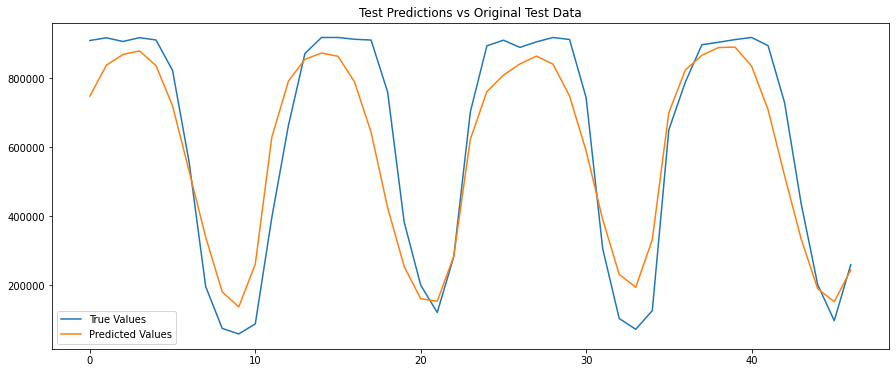

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

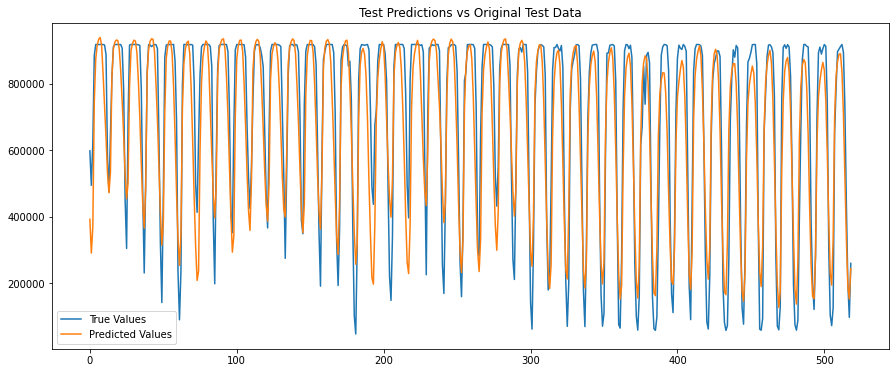

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()